# Training of TinyYOLOv2 with Keras using the TensorFlow backend

This notebook implements TinyYOLOv2 with Keras and demonstrates how to train and export a model.

Authors(s): *Martin Fränzl*

## Required packages

In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense, Input, Reshape, Lambda
from keras.layers.advanced_activations import LeakyReLU #, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

from keras import backend as K
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from preprocessing import parse_annotation, BatchGenerator
from utils import decode_netout, draw_boxes

# Required for GPU support on Ubuntu
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0" # Change to "1" to use a 2nd GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# Check the TensorFlow version
print(tf.__version__)

1.13.1


In [3]:
# Check available GPUs
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Path definitions
Setup the paths to the training and validation datasets and define a name for the model.

In [4]:
path = './Dataset/'
train_image_folder = path + 'train_images/' 
train_annot_folder = path + 'train_annotations/'
valid_image_folder = path + 'valid_images/' 
valid_annot_folder = path + 'valid_annotations/' 

In [5]:
model_name = 'TinyYOLOv2_416x416_Spots+Rings'

## Parameters

In [6]:
LABELS = ['Spot', 'Ring']

IMAGE_H, IMAGE_W = 416, 416
GRID_H, GRID_W = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.6 
NMS_THRESHOLD    = 0.45
ANCHORS = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]

NO_OBJECT_SCALE  = 0.5
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 8
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

## Define the network architecture

In [7]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(16, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2 - 5
for i in range(0,4):
    x = Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', name='conv_' + str(i+2), use_bias=False)(x)
    x = BatchNormalization(name='norm_' + str(i+2))(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(x)

# Layer 7 - 8
for i in range(0,2):
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_' + str(i+7), use_bias=False)(x)
    x = BatchNormalization(name='norm_' + str(i+7))(x)
    x = LeakyReLU(alpha=0.1)(x)

# Layer 9 (Object Detection Layer)
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_9')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#model.summary()

**Randomize weights of the last layer**

In [9]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

## Perform training

**Define loss function**

In [10]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
    
    return loss

**Define BatchGenerator**

In [11]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

In [12]:
def normalize(image):
    return image/255.

In [13]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
valid_batch = BatchGenerator(valid_imgs, generator_config, jitter=False, norm=normalize)

**Define callback functions**

In [14]:
checkpoint = ModelCheckpoint(path + model_name + '_weights.h5', 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min', 
                             period = 1)

early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.001, 
                           patience = 3, 
                           mode = 'min', 
                           verbose = 1)

**Start training**

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 10, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint], # early_stop 
                    max_queue_size   = 3)

## Perform detection on test image

In [15]:
model.load_weights(path + model_name + "_weights.h5")

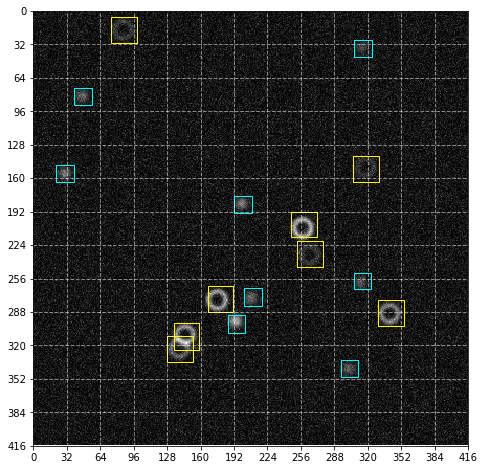

In [17]:
OBJ_THRESHOLD    = 0.6
NMS_THRESHOLD    = 0.45

image = cv2.imread(path + '/test_images/image_0000.jpg')
dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))

fig, ax = plt.subplots(1, 1, figsize=(8,8))

input_tensor = cv2.resize(image, (416, 416))
input_tensor= input_tensor / 255.
input_tensor= input_tensor[:,:,::-1]
input_tensor = np.expand_dims(input_tensor, 0)

netout = model.predict([input_tensor, dummy_array])

bboxes = decode_netout(netout[0],
                       obj_threshold = OBJ_THRESHOLD,
                       nms_threshold = NMS_THRESHOLD,
                       anchors = ANCHORS, 
                       nb_class = CLASS)
            
draw_boxes(image[:,:,0]/255., ax, bboxes, ['cyan', 'yellow'])

plt.imshow(image);

plt.xticks(np.arange(0, 417, step=32))
plt.yticks(np.arange(0,417, step=32))
plt.xlim(0, 416)
plt.ylim(416, 0)
plt.grid(lw=1, color='w', ls='--', alpha=0.5)  

plt.show()

## Freeze model and export as (*.pb) file

In [24]:
def freeze_session(output_node_names, destination, name):

    K.set_learning_phase(0)
    session = K.get_session()
    

    #tf.identity(model.output, name='output_1') # alias output name of the model 
    with session.as_default():
        # Convert variables into constants so they will be stored into the graph def
        output_graph_def = tf.graph_util.convert_variables_to_constants(session, session.graph.as_graph_def(), output_node_names)
        tf.train.write_graph(output_graph_def, destination, name, as_text=False)

    #tf.keras.backend.clear_session()

In [25]:
input_node_name = model.input[0].name.split(':')[0]
output_node_name = model.output.name.split(':')[0]

freeze_session([output_node_name], path, model_name + '.pb');

INFO:tensorflow:Froze 42 variables.
INFO:tensorflow:Converted 42 variables to const ops.


## Export *.ini file

In [26]:
import configparser
from datetime import date

In [ ]:
config = configparser.ConfigParser()
config.optionxform = lambda option: option  # preserve case for letters

config.add_section('General')
config.set('General', 'Training Set', str(model_name))
config.set('General', 'Date', str(date.today().strftime("%d/%m/%Y")))
config.set('General', 'IMAGE_H', str(IMAGE_H))
config.set('General', 'IMAGE_W', str(IMAGE_W))
config.set('General', 'GRID_H', str(GRID_H))
config.set('General', 'GRID_W', str(GRID_W))
config.set('General', 'BOXES', str(BOX))
config.set('General', 'LABELS', ','.join(str(l) for l in LABELS))
config.set('General', 'CLASSES', str(len(LABELS)))
config.set('General', 'INPUT_NODE_NAME', input_node_name)
config.set('General', 'OUTPUT_NODE_NAME', output_node_name)
config.set('General', 'ANCHORS', ','.join(str(a) for a in ANCHORS))

with open(path + model_name + '.ini', 'w') as configfile:    # save
    config.write(configfile)